### Library install :
- Python : `3.6`
- `conda install numpy`
- `conda install matplotlib`
- `conda install pandas`
- `conda instal scikit-learn`
- Opsi Tensorflow (**pilih salah satu**) :
    - `pip install tensorflow-gpu==1.12 --user` --> TF GPU | CUDA 9.0 | CuDNN 7.0 | GPU Driver Ver >= 385.xx
    - `pip install tensorflow-gpu==2.1 --user` --> TF GPU | CUDA 10.0 | CuDNN 7.6 | GPU Driver Ver >= 411.xx
    - `pip install tensorflow==2.1 --user` --> TF CPU
- `conda install keras`
- `conda install -c conda-forge ipykernel`

In [1]:
# check available GPU
import tensorflow as tf

# tensorflow  2.x 
#tf.config.list_physical_devices('GPU') 

# tensorflow 1.x
with tf.Session() as sess:
    print(sess.list_devices())

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 13003277031091968718), _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 1502406247, 17805063501104618059)]


In [2]:
tf.__version__

'1.12.0'

In [3]:
import os
# if GPU is not available, just disable GPU 
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

dataset_folder = 'dataset/'
filenames = []
for filename in os.listdir(dataset_folder):
        filenames.append(filename)

In [4]:
filenames

['mitbih_test.csv', 'mitbih_train.csv']

In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [6]:
train_df=pd.read_csv(dataset_folder + 'balanced_mitbih_train.csv',header=None)
test_df=pd.read_csv(dataset_folder + 'mitbih_test.csv',header=None)

## Dataset MIT-BIH
Dataset MIT-BIH terdiri dari 188 kolom, dimana kolom ke 188 merupakan katerori/class.

In [7]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


___
## Add Noise

- pada bagian ini kita tambahkan gaussian noise pada signal ECG 
- Noise yang akan ditambahkan adalah **Additive White Gaussian Noise (AWGN)**.
- Pada AWGN nilai rata-rata $\mu$ = 0, sehingga untuk tiap Gaussian random variable $X$, non-central second [moment](https://en.wikipedia.org/wiki/Normal_distribution#Moments) *E*[$X^{2}$] adalah: <br><br>
*E*[$X^{2}$] = $\mu^{2}$ + $\sigma^{2}$ <br><br>
sehingga, <br>
*E*[$X^{2}$] = $\sigma^{2}$ <br><br>
untuk, <br>
*E*[$X^{2}$] dalam konteks ini merupakan rata-rata noise, <br><br>
$NoiseAvg$ = $10^{NoiseAvg[db]/10}$ <br><br>
konversi baliknya ke-db, <br>
$NoiseAvg[db] = 10\times log(NoiseAvg)$ <br><br>
NoiseAvg bisa didapatkan dari formula $SNR$, <br>
$SNR[db]= Signal[db] - NoiseAvg[db]$ 
<br><br>
sehingga jika $SNR$ diset pada nilai tertentu, bisa didapatkan variance $\sigma^{2}$ yang nantinya dapat digunakan untuk menghasilkan white noise. 
- untuk menghasilkan white noise bisa digunakan library `numpy.random.normal()` dengan parameter `step` = $\sigma$ (std deviation)

In [27]:
def add_AWGN_noise(signal, target_snr_db=18):
    
    # Calculate signal and convert to dB 
    sig_avg = np.mean(signal)
    sig_avg_db = 10 * np.log10(sig_avg)
    
    # Calculate noise : 
    # SNR_db = Signal_db - Noise_db
    noise_avg_db = sig_avg_db - target_snr_db
    noise_avg_watts = 10 ** (noise_avg_db / 10)
    
    # Generate an sample of white noise
    mean_noise = 0
    sigma = np.sqrt(noise_avg_watts)
    noise = np.random.normal(mean_noise, sigma, len(signal))

    return (signal+noise)

In [28]:
def plot_noised_signal(signal, noised_signal):
    plt.figure(figsize=(15,4)) 

    plt.subplot(1,2,1)
    plt.plot(signal)
    plt.title("Original Signal")

    plt.subplot(1,2,2)
    plt.plot(noised_signal)
    plt.title("Noised Signal with AWGN")

    plt.tight_layout()
    plt.show()

### Add Noise to All Signal Dataset

In [31]:
X_train=train_df.iloc[:,:187].values
X_test=test_df.iloc[:,:187].values

In [32]:
X_train_noised = train_df.iloc[:,:187].apply(add_AWGN_noise, axis=1).values
X_test_noised = test_df.iloc[:,:187].apply(add_AWGN_noise, axis=1).values

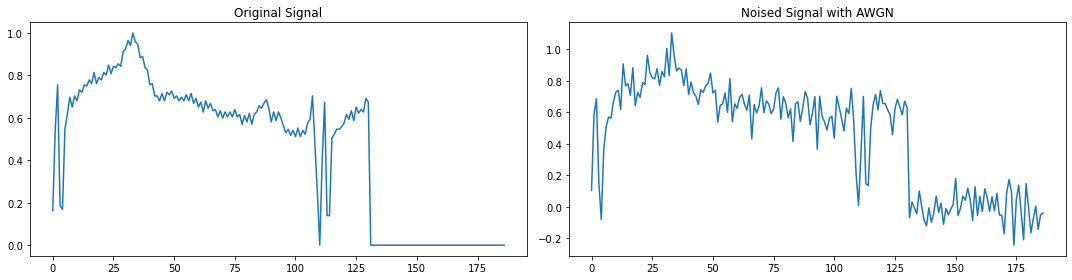

In [33]:
plot_noised_signal(X_train[0], X_train_noised[0])

___
# Denoising Signal

- Ditahap ini kita akan coba lakukan Denoising signal menggunakan Deep Learning Model yang sudah di trainign sebelumnya :
    - Denoising Deep AE : `best_denoising_deep_AE.h5`
    - Denoising CNN : `best_denoising_conv_AE.h5`
    - Denoising LSTM : `best_denoising_LSTM_AE.h5`<br>
![](resource/DAE.png)

#### Visualization util

In [49]:
def plot_model_history(history):
    
    fig, ax_loss = plt.subplots()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.show()

In [50]:
def plot_decoded_signal(decoded_signal, original_signal, name):
    plt.figure(figsize=(15,4))

    plt.subplot(1,2,1)
    plt.plot(decoded_signal)
    plt.title("Denoised Signal - " + name)

    plt.subplot(1,2,2)
    plt.plot(original_signal)
    plt.title("Original Signal")

    plt.tight_layout()
    plt.show()

# Classification CNN